In [35]:
%reload_ext autoreload
%autoreload 2

In [36]:
# imports
import os
import ast
import math
import json
import requests
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import ipywidgets as widgets

import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


from scipy import stats
from datetime import datetime as dt
from ipywidgets import interact, interactive, fixed, interact_manual

from IPython.display import HTML
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [37]:
import helpers


movies, characters = helpers.import_movies_data("./data/")


FileNotFoundError: [Errno 2] No such file or directory: './data//CMU/movie.metadata.tsv'

In [ ]:
movies.head(3)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,tconst,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0228333,4.9,56928.0
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,tt0002894,6.8,17.0
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,tt0029852,6.8,2268.0


In [ ]:
#### this section explores the relationship between the ethnic make-up of a movie's cast and its ratings 

In [ ]:
### research question 1: how has actors' ethnic demographics changed over the years in the global movies industry? 

(375,)


<Axes: >

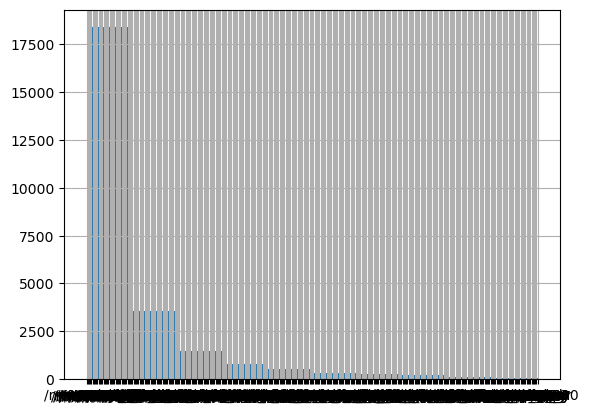

In [ ]:
## data preprocessing
# NOTE: INNER join movies with characters (ignore if either side's info is missing)
movies_ratings_characters = pd.merge(movies, characters, how='inner', on=['wikipedia_movie_ID'])
movies_ratings_characters.head(3)

## exploratory data analysis
# show distribution of ethnicities (across all movies and across all years)
ethnicity_count = movies_ratings_characters['actor_ethnicity'].value_counts()
print(ethnicity_count.shape)
# half ethnicities have frequency < 10
# print(ethnicity_count.values)

movies_ratings_characters['actor_ethnicity'].hist()

In [ ]:
## compute the number of actor ethnicities in each decade
# add decade column
movies_ratings_characters['decade'] = movies_ratings_characters['year_released'].apply(lambda x: int(x/10)*10)
# compute the number of ethnicities for each decade based on actors who have at least one film released in that decade
# NOTE: missing values in ethnicity column are ignored
decade_ethnicity = pd.crosstab(movies_ratings_characters['decade'], movies_ratings_characters['actor_ethnicity'])
decade_num_ethnicities = decade_ethnicity.apply(lambda x: (x != 0).sum(), axis=1)

# NOTE: last decade's drop expla
# ined by data collected till 2013 
display(decade_num_ethnicities)

decade
1900      1
1910     12
1920     27
1930     39
1940     55
1950     72
1960     80
1970    126
1980    174
1990    239
2000    312
2010    227
dtype: int64

<Axes: xlabel='decade'>

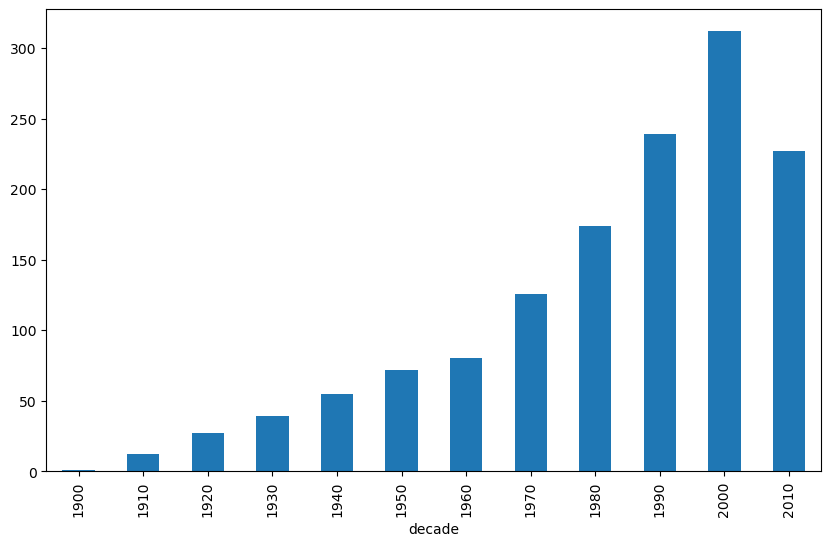

In [ ]:
# plot the number of actor ethnicities in each decade
decade_num_ethnicities.plot.bar(stacked=True, figsize=(10, 6))

In [ ]:
# answers research question 1: in the global movie industry, actors are coming from increasingly more diverse ethnic backgrounds over the years

In [ ]:
### research question 2: with increasingly diverse workforce, is the global film industry producing more ethnically diverse films over the years? (representation)

(12574, 26)
count    12574.000000
mean         6.152505
std          1.032984
min          1.300000
25%          5.600000
50%          6.300000
75%          6.800000
max          9.900000
Name: averageRating, dtype: float64
(2644, 26) 0.2102751709877525


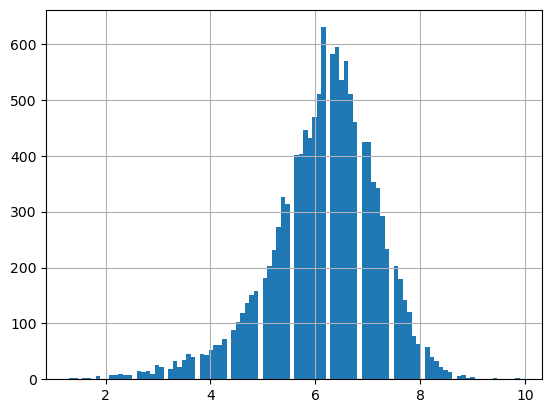

In [ ]:
## exploratory data analysis 
# filter dataset to unique movies
# NOTE: number of movies (with ratings) shrank from 14369 to 12574 after joining with characters
df_unique_movies = movies_ratings_characters.drop_duplicates(subset=['wikipedia_movie_ID']).reset_index().set_index('wikipedia_movie_ID')
print(df_unique_movies.shape)

# show distribution of movie ratings
print(df_unique_movies['averageRating'].describe())
# roughly normally distributed
df_unique_movies['averageRating'].hist(bins=100)

high_ratings_movies = df_unique_movies[df_unique_movies['averageRating'] >= 7.0]
# 21.03% are high-rating films
print(high_ratings_movies.shape, high_ratings_movies.shape[0]/df_unique_movies.shape[0])

# NOTE: hereafter define good films as films with IMDB rating >= 7.0

count    12574.000000
mean         1.964291
std          1.638365
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: actor_ethnicity, dtype: float64
(3020,) 0.24017814537935422


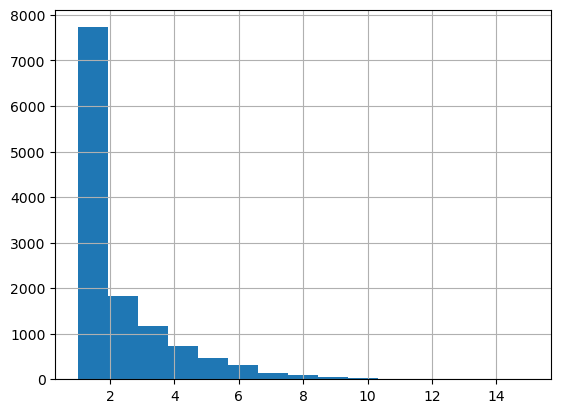

In [ ]:
# calculate number of ethnicities per film
# NOTE: missing values in ethnicity column are ignored
num_ethnicities_by_movie = movies_ratings_characters.groupby('wikipedia_movie_ID')['actor_ethnicity'].nunique()
# NOTE fill with 1 if no actor ethnicity info is available for a movie
num_ethnicities_by_movie[num_ethnicities_by_movie == 0] = 1

# show distribution of number of ethnicities per film (across all years)
# power law

print(num_ethnicities_by_movie.describe())
num_ethnicities_by_movie.hist(bins=num_ethnicities_by_movie.max())

ethnic_diverse_movies = num_ethnicities_by_movie[num_ethnicities_by_movie >= 3]
# 24.02% films have cast whose number of ethnicities >= 3
print(ethnic_diverse_movies.shape, len(ethnic_diverse_movies) / len(num_ethnicities_by_movie))

# NOTE: hereafter, define ethnically diverse films as number of different ethnicities in cast members >= 3

In [ ]:
# add number of ethnicities for a movie as a new column
df_unique_movies = df_unique_movies.assign(num_ethnicities=num_ethnicities_by_movie)

# plot the number of ethnically diverse films in each decade

# plot the number of good films in each decade

# plot the number of ethnically diverse good films in each decade



In [ ]:
# answers research question 2: an increasing number of ethnically diveres films are produced over the years (change in ethnic makeup of the acting workforce is reflected on the silver screen)